In [166]:
import numpy as np
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
from scipy import stats
pd.set_option("display.date_dayfirst", True)
plt.style.use('seaborn-whitegrid') #matplotlib now also has styles which can be imported for ease
%matplotlib inline

In [290]:
filepath = 'Data to Import/OP_pickles/OP_all_data_5perc_cutoff_NEW-2017.pkl'
all_data = pd.read_pickle(filepath)
#all_data = pd.read_csv(filepath)

## add a column with the number of days since 01/01/15
#all_data['Day'] = (all_data['Date']-all_data['Date'].min()) / np.timedelta64(1,'D')

## set some of the values to Farmer for Linac 13 and 20
#for i, row in all_data[(all_data['Centre_ID']==51)].iterrows():
#    if all_data['Measurement_Device'][i] == 'Farmer':
#        all_data.set_value(i,'Farmer','Farmer')
#    else:
#        all_data.set_value(i,'Farmer','Non-Farmer')
#    #all_data.set_value(i,'Farmer','Non-Farmer')

In [291]:
#pd.to_datetime(all_data['Date'],dayfirst=True)
#all_data.Date.dt.normalize()
#all_data['Date']
#all_data.head(3)

In [292]:
#all_data['weekday'] = all_data['Date'].apply(lambda x:x.weekday())

In [293]:
## fix date format after importing from csv...
#all_data['Short_Date']= pd.to_datetime(all_data['Date'],dayfirst=True)
#all_data['Date']= pd.to_datetime(all_data['Date'],dayfirst=True)
#all_data['weekday'] = all_data['Date'].apply(lambda x:x.weekday())
#all_data['Date'] = all_data['Short_Date'].apply(lambda x:x)
#pd.to_datetime(all_data['Date'],dayfirst=True)

In [294]:
all_data.head(3)

,Centre_ID,NHS_PP,Group,Linac_Manufacturer,Linac_Model,Linac_Install_Date,Linac_ID,Date,Measurement_Device,OP_Dif,Recording,Comments,Week,Month,Farmer,date_delta,Short_Date,weekday
0,1,NHS,5,Elekta,Agility,2014,1,2015-01-06,Farmer,0.5,Paper,NaN,2,1,Farmer,5.0,06/01/2015,1
1,1,NHS,5,Elekta,Agility,2014,1,2015-01-16,Farmer,-0.9,Paper,NaN,3,1,Farmer,15.0,16/01/2015,4
2,1,NHS,5,Elekta,Agility,2014,1,2015-01-19,Farmer,-0.6,Paper,NaN,4,1,Farmer,18.0,19/01/2015,0


In [295]:
all_data['Date'][0]

Timestamp('2015-01-06 00:00:00')

In [296]:
def mad(data):
    ## calculation of the median absolute deviation
    ## https://en.wikipedia.org/wiki/Median_absolute_deviation
    return np.median(np.absolute(data - np.median(data)))

t1 = time.time()

for i in range(1000):
    madstat = mad(all_data['OP_Dif'])

t2 = time.time()

print(t2-t1)

1.1451144218444824


In [297]:
import statsmodels.api as stat

In [298]:
## comparison with the function in statsmodels. - Same answer given with scaling factor set to 1.
## removing the scaling factor (c) gives a larger result and scales to approximate the SD.

t1 = time.time()

for i in range(1000):
    altmad = stat.robust.scale.mad(all_data['OP_Dif'],c=1)
    
t2 = time.time()
    
print(t2-t1)

## the statsmodels function is approx 30% quicker.

0.9110910892486572


In [299]:
## how many use paper records?

group = all_data.groupby(by='Recording',axis=0)
paper = group.get_group('Paper')
#paper = group.get_group('Paper')

print(paper['Centre_ID'].unique()) # centres that specified only using paper.
## also 2 more that use paper for daily records.
#print(all_data['Recording'].unique())

[ 1  3 12 15 39 42]


In [300]:
## how many centres provided farmer+other measurements

##1 filter to get list of centres with farmer data

farmer_centres = all_data[all_data['Farmer']=='Farmer']['Centre_ID'].unique()
farmer_centres

farmer_centres_data = all_data[all_data['Centre_ID'].isin(farmer_centres)]
farmer_centres_data_with_other = farmer_centres_data[farmer_centres_data['Farmer']!='Farmer']
unique_farmer_centres_data_with_other = farmer_centres_data[farmer_centres_data['Farmer']!='Farmer']['Centre_ID'].unique()
print(len(unique_farmer_centres_data_with_other)) # number of centres with 2 sets of data = 29

f = farmer_centres_data_with_other ## the smaller dataframe for use
f_centres = sorted(farmer_centres_data_with_other['Centre_ID'].unique())

full_data_both = all_data['Centre_ID']
print(f_centres)

## filter to list only centres whichhad farmer and then filter this to centres which had other measurmenets

30
[1, 2, 6, 10, 12, 14, 16, 17, 19, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 41, 46, 47, 48, 49, 51]


8


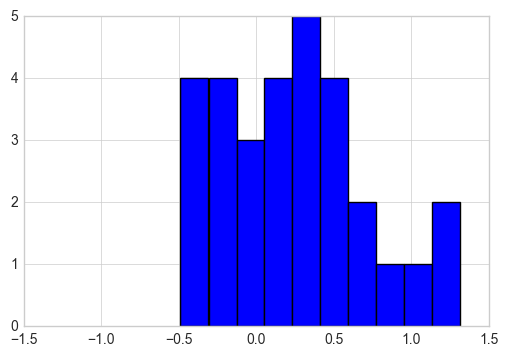

In [301]:
## list of centres with both data: f_centres

## filter all _data to oly have htese centres

both_data = all_data[all_data['Centre_ID'].isin(f_centres)]
#sorted(both_data['Centre_ID'].unique())
difs = []

for centre in f_centres:
    farmer = both_data[(both_data['Farmer']=='Farmer') & (both_data['Centre_ID']==centre)]
    non = both_data[(both_data['Farmer']!='Farmer') & (both_data['Centre_ID']==centre)]
    
    farmer_mean = farmer['OP_Dif'].mean()
    non_mean = non['OP_Dif'].mean()
    dif = farmer_mean - non_mean
    difs.append(dif)
#print(difs)

#plt.plot(f_centres,difs, marker='o', ls='')
thres=0.5
#plt.axhline(thres)
#plt.axhline(-thres)
#plt.ylim(-1.5,1.5)

plt.hist(difs)
plt.xlim(-1.5,1.5)

num = 0
for i in difs:
    if abs(i) > thres:
        num = num+1
        
print(num)        

In [302]:
all_data['Date'][0]

Timestamp('2015-01-06 00:00:00')

In [303]:
##need to get the max date in the table and then take away the dif to allow the number of loops to be calculated

#i = 1 to ??

i = 3

#start_date = dt.date(year=2015,month=2,day=i)
start_date = dt.date(2015,2,i)
start_date = pd.to_datetime('03-Feb-2015')
dif_days = 5
end_date = start_date + dt.timedelta(days=dif_days)
## ideally also ignore weekends?
## could remove all weekend data first and then just assume treatment on each day.
## then add a column containing number of days since the start and use this for filtering

datemask = (all_data['Date'] >= start_date) & (all_data['Date'] <= end_date)

date_lim = all_data.loc[datemask]

date_lim.describe()

,Centre_ID,Group,Linac_ID,OP_Dif,Week,Month,date_delta,weekday
count,758.000000,758.000000,758.000000,758.000000,758.0,758.0,758.000000,758.000000
mean,21.750660,4.263852,102.084433,-0.352279,6.0,2.0,34.626784,2.575198
std,15.885982,2.236136,59.173866,0.850530,0.0,0.0,1.245089,1.222431
min,1.000000,1.000000,1.000000,-3.500000,6.0,2.0,33.000000,1.000000
25%,10.000000,3.000000,55.000000,-0.850000,6.0,2.0,33.708446,1.250000
50%,18.000000,4.000000,100.000000,-0.300000,6.0,2.0,35.000000,3.000000
75%,36.000000,6.000000,148.000000,0.200000,6.0,2.0,36.000000,4.000000
max,52.000000,9.000000,204.000000,2.000000,6.0,2.0,38.000000,6.000000


In [304]:
## get only weekday data as most reliable and can then do set time periods easier?

weekday_data = all_data[all_data['weekday'] <= 4] # dayofweek goes from 0-6
#for i in weekday_data.index[0:1000]:
#    plt.axvline(all_data['Date'][i])
#plt.xlim(dstart,dend)
print(len(weekday_data))
print(len(all_data))
print(len(all_data)-len(weekday_data))
## only 1011 data points at the weekend (4%), so probably not going to affect stats much.

23490
24501
1011


-0.24823084759951186 0.16657771959979792


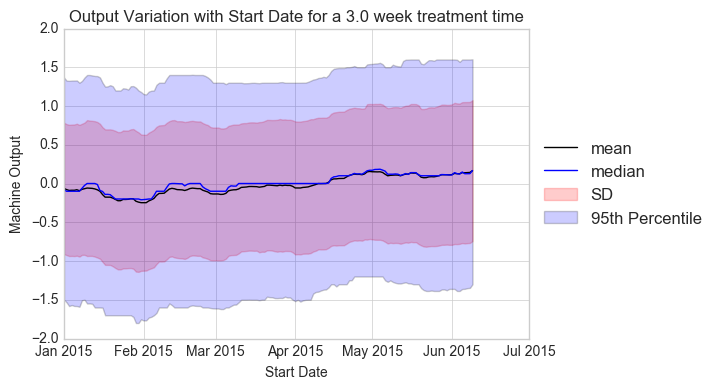

In [305]:
## 1 - filter by date

dif_days = 7*3
dif_weeks = dif_days/7
step_size = dt.timedelta(days=1)

start_date = dt.date(2015,1,1)
end_date = dt.date(2015,7,1) - dt.timedelta(days=dif_days) # last date of interest minus difference in weeks of interest

## if want ot limit to specific linacs, tehn do this before the date filter....?
linacs_interest = sorted(all_data['Linac_ID'].unique())
#linacs_interest = [1]

date_interest = start_date

all_dates = []
all_means = []
all_medians = []
all_sds = []
all_95perc = []
all_5perc = []
all_n = []

while date_interest < end_date:
    ## set the start and end dates for filtering the data
    start_date_interest = date_interest
    end_date_interest = start_date_interest + dt.timedelta(days=dif_days)
    
    ## filter the data
    lim_data = all_data[(all_data['Date']>=start_date_interest) &
                        (all_data['Date']<end_date_interest) &
                        (all_data['Linac_ID'].isin(linacs_interest)) &
                        (all_data['Centre_ID'] != 0)]
    
    ## calculate the stats
    mean_interest = lim_data['OP_Dif'].mean()
    median_interest = lim_data['OP_Dif'].median()
    sd_interest = lim_data['OP_Dif'].std()
    perc95_interest = np.percentile(lim_data['OP_Dif'],95)
    perc5_interest = np.percentile(lim_data['OP_Dif'],5)
    n_interest = len(lim_data)
    
    ## compile the stats
    all_dates.append(start_date_interest)
    all_means.append(mean_interest)
    all_medians.append(median_interest)
    all_sds.append(sd_interest)
    all_95perc.append(perc95_interest)
    all_5perc.append(perc5_interest)
    all_n.append(n_interest)
    #print(perc5_interest)
        
    ## increment the date of interest for the next loop
    date_interest = date_interest + dt.timedelta(days=1)
    
## get upper and lower valeus for +/- SD (or multiple of)
sd_mult = 1

all_means_pos_sds = [(all_means[i] + sd_mult*all_sds[i]) for i in range(len(all_means))]
all_means_neg_sds = [(all_means[i] - sd_mult*all_sds[i]) for i in range(len(all_means))]
    
plt.plot(all_dates,all_means,label='mean',color='black')
plt.plot(all_dates,all_medians,label='median')
#plt.plot(all_dates,all_sds)
plt.fill_between(all_dates,all_means_pos_sds,all_means_neg_sds,alpha=0.2,label = 'SD',color='red')
plt.fill_between(all_dates,all_95perc,all_5perc,alpha=0.2,label = '95th Percentile')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Output Variation with Start Date for a ' + str(dif_weeks) + ' week treatment time')
#plt.ylim(-3,3)
plt.xlim('01-Jan-15','01-Jul-15')
plt.xlabel('Start Date')
plt.ylabel('Machine Output')
#plt.plot(all_data['Date'],all_data['OP_Dif'],ls='',ms=1,alpha=0.1,marker='o')   
print(min(all_means),max(all_means))

### Results
#### 8 Week Treatment
Dependant on the patients start date and assuming an 8 week treatment length.
The SD of OP varies between 0.84-0.89.
The mean varies between -0.14 and +0.14 (taking into account all linacs)
For an individual centre (e.g. centre 1) the mean varies between -0.4 and +0.05
For linac 1 the mean varies between -0.74 and -0.41.
    - Would be useful to get these results for each linac? i.e. get the range for each linac.


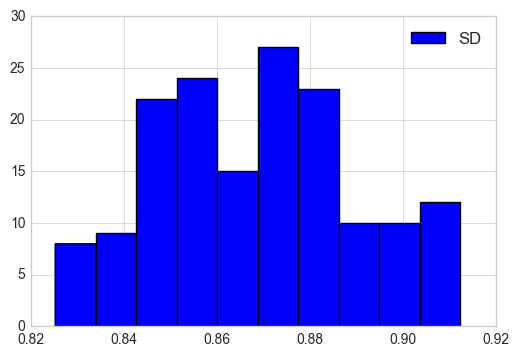

In [306]:
#plt.hist(all_means,histtype='step',label='Mean')
#plt.hist(all_medians,histtype='step',label='Median')
plt.hist(all_sds,histtype='bar',label='SD',bins=10)
#plt.xlim(-3,3)
plt.legend(loc='best')

0.8861121563577151


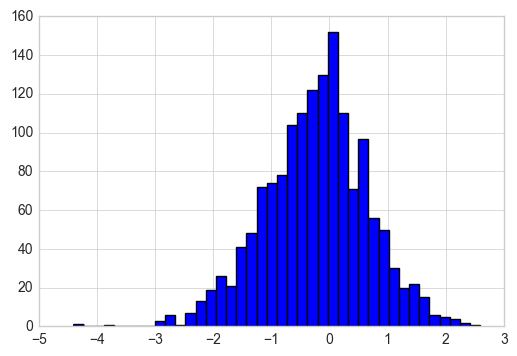

In [307]:
## plot of output variation (as histogram) between set date range

startd = '10-Feb-15'
endd = '20-Feb-15'
startd = dt.date(2015,2,10)
endd = dt.date(2015,2,20)

lim_op = all_data[(all_data['Date'] >= startd) & (all_data['Date']<endd)] # febs data
#plt.plot(lim_op['Date'],lim_op['OP_Dif'], marker='o',alpha=0.2,ms=2,ls='')
plt.hist(lim_op['OP_Dif'],bins=40)
print(lim_op['OP_Dif'].std())

## this shows the SD in april is about 0.8 which does not agree with the plot produced previously which shows 0.3.
## need to correct this.

## could add on a column with number of days to simplify the filtering??

-0.24016931874110653


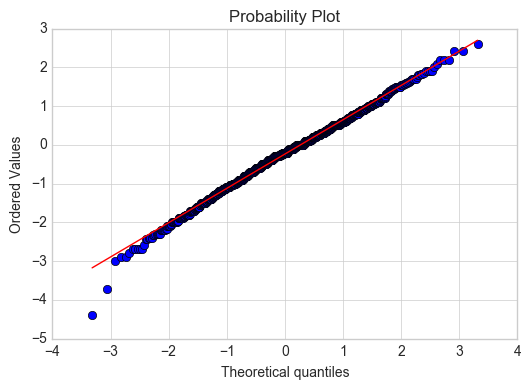

Rsquared: 0.995403853618
Slope: 0.784087265306
Intercept: 0.0576813016646


In [308]:
## plot a 'normal proabbility plot' to compare the percintiles with those of a noram distribution
## https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.stats.probplot.html
test = np.random.normal(0,0.8,1000)
res=stats.probplot(lim_op['OP_Dif'],plot=plt)
print(lim_op['OP_Dif'].mean())
plt.show()
print('Rsquared:',res[1][2]**2)
print('Slope:',res[1][0]**2)
print('Intercept:',res[1][1]**2)
## straight line on the plot matches data well indicating normal distribution


#### OP variation using all linacs at once(above the data is split by linac to get each of their SD etc)
- mean and median will be dif to above

[5.2, 4.9, 7.85, 11.15, 13.200000000000001, 16.8]


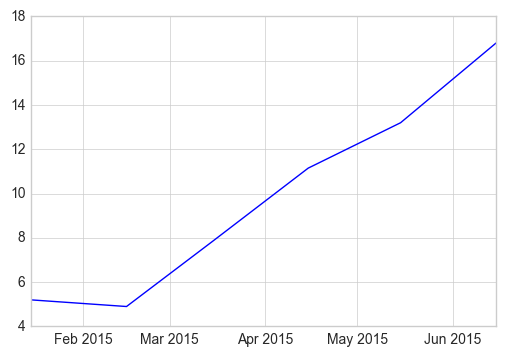

In [309]:
#### interesting plot of average temperatures...?

month = [1,2,3,4,5,6]
tempmax = [8.8,8,11.6,16.3,17.6,22.2]
tempmin = [1.6,1.8,4.1,6,8.8,11.4]
tempmid = []

for i in range(len(month)):
    mid = (tempmax[i]+tempmin[i])/2
    tempmid.append(mid)
print(tempmid)

temp_dates = []

for i in range(len(month)):
    temp_date = dt.datetime(year=2015,month=(i+1),day=15)
    temp_dates.append(temp_date)
    
plt.plot(temp_dates,tempmid)
####

### What is the distribution of the number of linacs within each centre?
- Do large centres have larger variability?
- Use quartiles to specify s/m/l centres

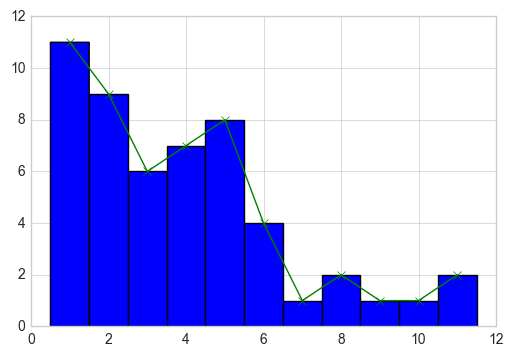

completed


In [310]:
plt.style.use('seaborn-whitegrid')

## list of each centre
centres = sorted(all_data['Centre_ID'].unique())
#print(sorted(centres))

n_linacs = []

for centre in centres:
    ## filter the data to get a single centre
    centre_data = all_data[all_data['Centre_ID']==centre]

    ## count number of unique linacs for that centre
    n = centre_data['Linac_ID'].unique()
    n_linacs.append((centre,len(n),n)) #0=Centre_ID, 1= n_linacs, 2= linac_IDs
    #print(centre,len(n),sorted(n))

#print([x[1] for x in n_linacs])
binwidth=1
data = [x[1] for x in n_linacs]

n_plt,bins_plt,patches=plt.hist(data,bins=np.arange(min(data), max(data) + binwidth, binwidth), align='left')
plt.plot(bins_plt[:-1],n_plt,lw=1,marker='x')
plt.xlim(0,12)
#savename='plt-styles/plt-'+style+'.png'
plt.show()
#plt.savefig(savename, bbox_inches='tight', dpi=300)
#plt.close()
print('completed')

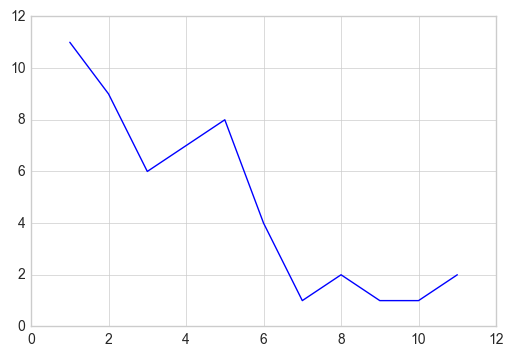

In [311]:
plt.plot(bins_plt[:-1],n_plt)

In [312]:
## get the medina/quartile values

perc_25 = np.percentile(data,25)
perc_50 = np.percentile(data,50)
perc_75 = np.percentile(data,75)
print(perc_25,perc_50,perc_75)
## 25th perc = 2 so 1 or 2 linacs = small centre
## 50th perc = 3.5 so 3,4,5 linacs = mediam
## 75th perc = 5 so 6+ linacs = large centre?

2.0 3.5 5.0


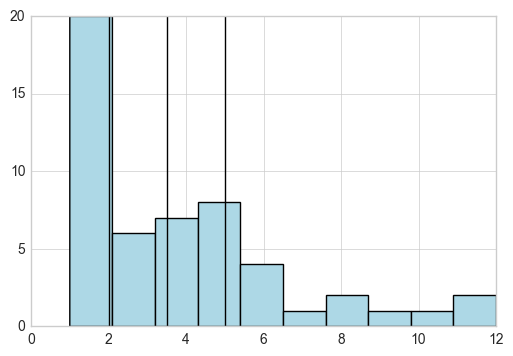

In [313]:
plt.hist(data,color='lightblue')
plt.axvline(perc_25, c='black')
plt.axvline(perc_50, c='black')
plt.axvline(perc_75, c='black')
plt.show()

In [314]:
## produce lists of the centre which are small/med/large
n_linacs

small_centres = [n_linacs[i] for i in range(len(n_linacs)) if (n_linacs[i][1]<=2)] ## small = 1,2 linacs
medium_centres = [n_linacs[i] for i in range(len(n_linacs)) if (n_linacs[i][1]>2) and (n_linacs[i][1]<=5)] ## med = 3,4,5 linacs
large_centres = [n_linacs[i] for i in range(len(n_linacs)) if (n_linacs[i][1]>5)] ## med = 3,4,5 linacs
large_centres

[(1, 8, array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)),
 (2, 12, array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype=int64)),
 (3, 6, array([21, 22, 23, 24, 25, 26], dtype=int64)),
 (10, 11, array([53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64)),
 (11, 9, array([64, 65, 66, 67, 68, 69, 70, 71, 72], dtype=int64)),
 (12, 8, array([73, 74, 75, 76, 77, 78, 79, 80], dtype=int64)),
 (16, 6, array([89, 90, 91, 92, 93, 94], dtype=int64)),
 (18,
  10,
  array([105, 100, 102, 103, 108, 104,  99, 106, 101, 107], dtype=int64)),
 (20, 7, array([114, 115, 116, 117, 118, 119, 120], dtype=int64)),
 (22, 6, array([135, 136, 138, 139, 140, 137], dtype=int64)),
 (27, 6, array([134, 155, 156, 157, 158, 159], dtype=int64))]

### Histogram of number of linacs separated into S/M/L

[2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2]
20
[4, 5, 4, 5, 4, 3, 4, 4, 5, 3, 5, 3, 3, 5, 3, 5, 3, 4, 4, 5, 5]
21
[8, 12, 6, 11, 9, 8, 6, 10, 7, 6, 6]
11


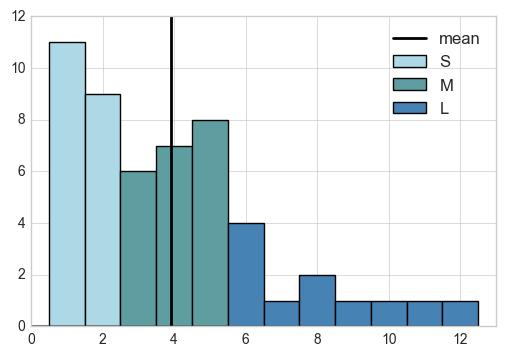

In [315]:

size_centre = [small_centres,medium_centres,large_centres]
size_label = ['S','M','L']
size_color = ['lightblue','cadetblue','steelblue']

i=0
all_n=[]
all_bins=[]
for size in size_centre:
    data = [x[1] for x in size]
    print(data)
    n,bins,patches=plt.hist(data,bins=np.arange(0, 13 + 1, 1), align='left',label=size_label[i],color=size_color[i])
    print(len(data))
    i=i+1
    all_n.append(n)
    all_bins.append(bins)
plt.xlim(0,13)
plt.axvline(np.mean([n_linacs[i][1] for i in range(len(n_linacs))]),c='black',lw=2,label='mean')
plt.legend(loc='best')
plt.show()


In [276]:
print(all_n)
print(all_bins)
#plt.plot(all_bins[:-3],all_n)

[array([  0.,  11.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.]), array([ 0.,  0.,  0.,  6.,  7.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  4.,  1.,  2.,  1.,  1.,  1.,  1.])]
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])]


[2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2]
20
[4, 5, 4, 5, 4, 3, 4, 4, 5, 3, 5, 3, 3, 5, 3, 5, 3, 4, 4, 5, 5]
21
[8, 12, 6, 11, 9, 8, 6, 10, 7, 6, 6]
11
[ 0.  0.  0.  0.  0.  0.  4.  1.  2.  1.  1.  1.  1.]


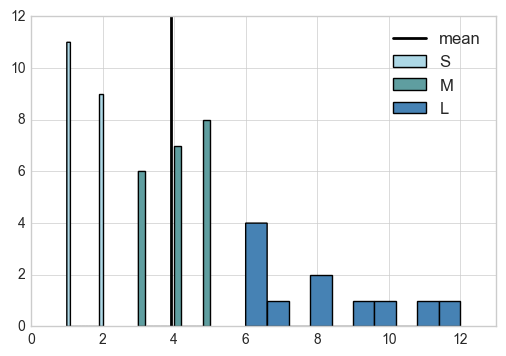

In [193]:
size_centre = [small_centres,medium_centres,large_centres]
size_label = ['S','M','L']
size_color = ['lightblue','cadetblue','steelblue']

i=0
for size in size_centre:
    data = [x[1] for x in size]
    print(data)
    plt.hist(data,label=size_label[i],color=size_color[i])
    print(len(data))
    i=i+1
plt.xlim(0,13)
plt.axvline(np.mean([n_linacs[i][1] for i in range(len(n_linacs))]),c='black',lw=2,label='mean')
plt.legend(loc='best')
print(n)
plt.show()

## Determine if a centre provided Farmer, Other or both types of data

In [277]:
for c_id in all_data['Centre_ID'].unique():
    c_data = all_data[all_data['Centre_ID']==c_id]
    if len(c_data['Farmer'].unique())==2:
        d_type = 'Both'
    elif c_data['Farmer'].unique()[0]=='Farmer':
        d_type = 'Farmer'
    elif c_data['Farmer'].unique()[0]=='Non-Farmer':
        d_type = 'Non-Farmer'
    else:
        d_type = 'Other'
    print(c_id,len(c_data['Farmer'].unique()),c_data['Farmer'].unique(),d_type)

1 2 ['Farmer' 'Non-Farmer'] Both
2 2 ['Farmer' 'Non-Farmer'] Both
3 1 ['Non-Farmer'] Non-Farmer
4 1 ['Non-Farmer'] Non-Farmer
5 1 ['Farmer'] Farmer
49 2 ['Farmer' 'Non-Farmer'] Both
6 2 ['Farmer' 'Non-Farmer'] Both
7 1 ['Farmer'] Farmer
8 1 ['Non-Farmer'] Non-Farmer
9 1 ['Non-Farmer'] Non-Farmer
10 2 ['Non-Farmer' 'Farmer'] Both
11 1 ['Non-Farmer'] Non-Farmer
12 2 ['Farmer' 'Non-Farmer'] Both
13 1 ['Farmer'] Farmer
14 2 ['Farmer' 'Non-Farmer'] Both
15 1 ['Farmer'] Farmer
16 2 ['Non-Farmer' 'Farmer'] Both
17 2 ['Non-Farmer' 'Farmer'] Both
18 1 ['Farmer'] Farmer
19 2 ['Farmer' 'Non-Farmer'] Both
20 1 ['Non-Farmer'] Non-Farmer
24 1 ['Non-Farmer'] Non-Farmer
25 2 ['Non-Farmer' 'Farmer'] Both
21 1 ['Non-Farmer'] Non-Farmer
26 2 ['Non-Farmer' 'Farmer'] Both
48 2 ['Non-Farmer' 'Farmer'] Both
28 2 ['Non-Farmer' 'Farmer'] Both
22 2 ['Non-Farmer' 'Farmer'] Both
34 2 ['Farmer' 'Non-Farmer'] Both
30 2 ['Farmer' 'Non-Farmer'] Both
32 2 ['Farmer' 'Non-Farmer'] Both
35 2 ['Farmer' 'Non-Farmer'] Both


In [288]:
## save the data as csv and pickle file - done after correcting some 'nan' values for centre 51
#all_data.to_csv('Data to Import/OP_pickles/OP_all_data_5perc_cutoff_NEW-2017b.csv')
#all_data.to_pickle('Data to Import/OP_pickles/OP_all_data_5perc_cutoff_NEW-2017.pkl')

In [279]:
test1234 = all_data[all_data['Centre_ID']==52]

In [280]:
test1234['Farmer'].unique()

array(['Non-Farmer'], dtype=object)

In [281]:
test1234['Measurement_Device']

23850    QA3
23851    QA3
23852    QA3
23853    QA3
23854    QA3
23855    QA3
23856    QA3
23857    QA3
23858    QA3
23859    QA3
23860    QA3
23861    QA3
23862    QA3
23863    QA3
23864    QA3
23865    QA3
23866    QA3
23867    QA3
23868    QA3
23869    QA3
23870    QA3
23871    QA3
23872    QA3
23873    QA3
23874    QA3
23875    QA3
23876    QA3
23877    QA3
23878    QA3
23879    QA3
        ... 
24471    QA3
24472    QA3
24473    QA3
24474    QA3
24475    QA3
24476    QA3
24477    QA3
24478    QA3
24479    QA3
24480    QA3
24481    QA3
24482    QA3
24483    QA3
24484    QA3
24485    QA3
24486    QA3
24487    QA3
24488    QA3
24489    QA3
24490    QA3
24491    QA3
24492    QA3
24493    QA3
24494    QA3
24495    QA3
24496    QA3
24497    QA3
24498    QA3
24499    QA3
24500    QA3
Name: Measurement_Device, dtype: object

In [282]:
#df1 = pd.read_csv(r'Data to Import\OP_pickles\OP_all_data_5perc_cutoff_NEW-2017.csv')

In [283]:
#df1.to_pickle('Data to Import\OP_pickles\OP_all_data_5perc_cutoff_NEW-2017.pkl')

In [289]:
#del all_data['Unnamed: 0']
#all_data.head(3)

In [287]:
all_data

,Centre_ID,NHS_PP,Group,Linac_Manufacturer,Linac_Model,Linac_Install_Date,Linac_ID,Date,Measurement_Device,OP_Dif,Recording,Comments,Week,Month,Farmer,date_delta,Short_Date,weekday
0,1,NHS,5,Elekta,Agility,2014,1,2015-01-06,Farmer,0.500000,Paper,NaN,2,1,Farmer,5.0,06/01/2015,1
1,1,NHS,5,Elekta,Agility,2014,1,2015-01-16,Farmer,-0.900000,Paper,NaN,3,1,Farmer,15.0,16/01/2015,4
2,1,NHS,5,Elekta,Agility,2014,1,2015-01-19,Farmer,-0.600000,Paper,NaN,4,1,Farmer,18.0,19/01/2015,0
3,1,NHS,5,Elekta,Agility,2014,1,2015-01-26,Farmer,-0.600000,Paper,NaN,5,1,Farmer,25.0,26/01/2015,0
4,1,NHS,5,Elekta,Agility,2014,1,2015-02-04,Farmer,0.060000,Paper,NaN,6,2,Farmer,34.0,04/02/2015,2
5,1,NHS,5,Elekta,Agility,2014,1,2015-02-16,Farmer,0.100000,Paper,NaN,8,2,Farmer,46.0,16/02/2015,0
6,1,NHS,5,Elekta,Agility,2014,1,2015-02-26,Farmer,0.100000,Paper,NaN,9,2,Farmer,56.0,26/02/2015,3
7,1,NHS,5,Elekta,Agility,2014,1,2015-03-09,Farmer,0.000000,Paper,NaN,11,3,Farmer,67.0,09/03/2015,0
8,1,NHS,5,Elekta,Agility,2014,1,2015-03-20,Farmer,0.200000,Paper,NaN,12,3,Farmer,78.0,20/03/2015,4
9,1,NHS,5,Elekta,Agility,2014,1,2015-03-24,Farmer,0.000000,Paper,NaN,13,3,Farmer,82.0,24/03/2015,1
